In [ ]:
# This notebook is for

In [4]:
import numpy as np
import nibabel as nib
from sklearn import preprocessing
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage
from numpy import load
import seaborn as sns
import matplotlib.pyplot as plt
from neuromaps import stats
from neuromaps import datasets, images, nulls, resampling
from neuromaps import parcellate
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
import pandas as pd
from neuromaps import datasets
from neuromaps import stats
from neuromaps.datasets import available_annotations
from neuromaps.datasets import available_tags
from neuromaps.datasets import fetch_annotation
from neuromaps import images
import matplotlib.cm
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi

### Setting path

In [2]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/Ach-phfMRI"

In [3]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/"
fig_path = main_path + "/figures/"

### Load BF seed data

In [23]:
# getting the surface BF label
BF_lh = images.load_gifti(data_path + "seed-BASF.L.bin.fsa5.shape.gii")
BF_rh = images.load_gifti(data_path + "seed-BASF.R.bin.fsa5.shape.gii")

In [24]:
BF_lh_data = BF_lh.agg_data()
BF_rh_data = BF_rh.agg_data()
BF_data = np.concatenate((BF_lh_data, BF_rh_data))

In [25]:
# scale the geodesic and BF data 
min_max_scaler = preprocessing.MinMaxScaler()
BF_scaled_data = min_max_scaler.fit_transform(BF_data.reshape(-1, 1))

In [26]:
np.where(BF_scaled_data == 1)

(array([11428, 16986]), array([0, 0]))

In [27]:
# change so the scaled data is binarized for BF seed
BF_scaled_data = np.where(BF_scaled_data == 0.5, 1, BF_scaled_data)
np.where(BF_scaled_data==1)

(array([   78,   600,  1335,  1337,  2438,  3255,  3256,  3257,  5448,
         5452,  7014,  7015,  8476,  8477,  9873,  9874,  9875,  9878,
         9879,  9880, 10324, 10443, 11205, 11206, 11428, 11754, 11755,
        11756, 11757, 11758, 13125, 13126, 13723, 13728, 14570, 14571,
        14572, 15678, 16583, 16584, 16585, 16986, 17610, 17612, 17613,
        17614, 17616, 17617, 17618, 17619, 17620, 18752, 20086, 20087,
        20095, 20096]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

### Load & visualize ALE maps (MNI space)

In [5]:
ALE_FWE = nib.load(data_path+f'AG_increase_18apr2023_C05_5k_ALE.nii')
ALE_raw = nib.load(data_path+f'AG_increase_18apr2023_ALE.nii')
ALE_Z = nib.load(data_path+f'AG_increase_18apr2023_Z.nii')

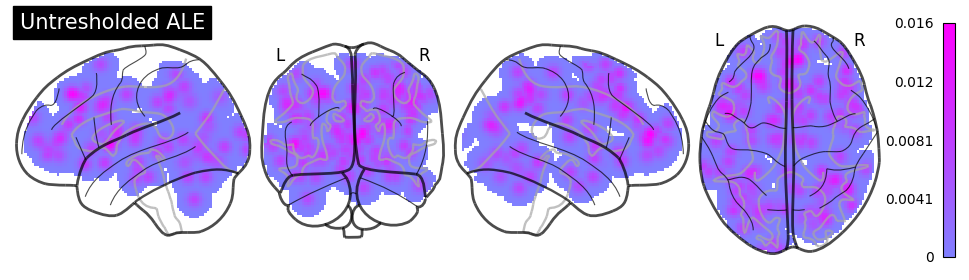

In [6]:
color = matplotlib.cm.get_cmap('cool')
plot_glass_brain(ALE_raw, colorbar=True, title=("Untresholded ALE"), display_mode='lyrz', plot_abs=False, cmap=color)

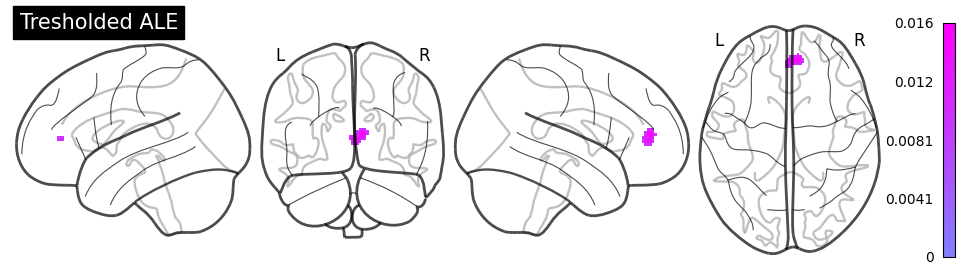

In [7]:
color = matplotlib.cm.get_cmap('cool')
plot_glass_brain(ALE_FWE, colorbar=True, title=("Tresholded ALE"), display_mode='lyrz', plot_abs=False, cmap=color)

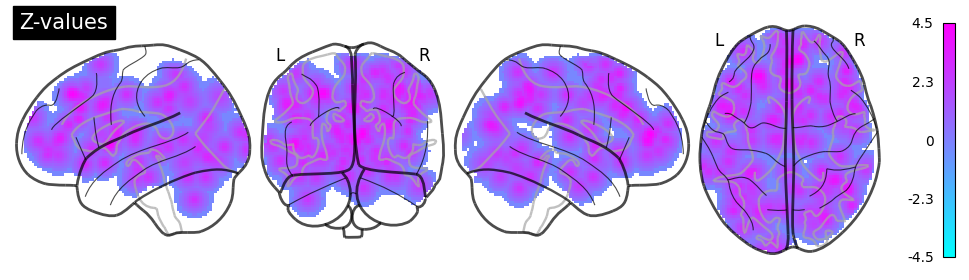

In [9]:
color = matplotlib.cm.get_cmap('cool')
plot_glass_brain(ALE_Z, colorbar=True, title=("Z-values"), display_mode='lyrz', plot_abs=False, cmap=color)

### Transform to fsaverage (10k) space and visualize

In [11]:
from neuromaps import transforms
ALE_raw_fsa5 = transforms.mni152_to_fsaverage(ALE_raw, '10k')
ALE_FWE_fsa5 = transforms.mni152_to_fsaverage(ALE_FWE, '10k')
ALE_Z_fsa5 = transforms.mni152_to_fsaverage(ALE_Z, '10k')

In [12]:
ALE_raw_fsa5_lh, ALE_raw_fsa5_rh = ALE_raw_fsa5
ALE_raw_fsa5_lh_data = ALE_raw_fsa5_lh.agg_data()
ALE_raw_fsa5_rh_data = ALE_raw_fsa5_rh.agg_data()
ALE_raw_data = np.concatenate((ALE_raw_fsa5_lh_data, ALE_raw_fsa5_rh_data))

In [13]:
ALE_FWE_fsa5_lh, ALE_FWE_fsa5_rh = ALE_FWE_fsa5
ALE_FWE_fsa5_lh_data = ALE_FWE_fsa5_lh.agg_data()
ALE_FWE_fsa5_rh_data = ALE_FWE_fsa5_rh.agg_data()
ALE_FWE_data = np.concatenate((ALE_FWE_fsa5_lh_data, ALE_FWE_fsa5_rh_data))

In [14]:
ALE_Z_fsa5_lh, ALE_Z_fsa5_rh = ALE_Z_fsa5
ALE_Z_fsa5_lh_data = ALE_Z_fsa5_lh.agg_data()
ALE_Z_fsa5_rh_data = ALE_Z_fsa5_rh.agg_data()
ALE_Z_data = np.concatenate((ALE_Z_fsa5_lh_data, ALE_Z_fsa5_rh_data))

In [41]:
# make medial wall equal to NAN
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

ALE_raw_fsa5_lh_data[np.logical_not(med_lh_data)] = np.nan
ALE_raw_fsa5_rh_data[np.logical_not(med_rh_data)] = np.nan
ALE_raw_data = np.concatenate((ALE_raw_fsa5_lh_data, ALE_raw_fsa5_rh_data))

ALE_FWE_fsa5_lh_data[np.logical_not(med_lh_data)] = np.nan
ALE_FWE_fsa5_rh_data[np.logical_not(med_rh_data)] = np.nan
ALE_FWE_data = np.concatenate((ALE_FWE_fsa5_lh_data, ALE_FWE_fsa5_rh_data))

ALE_Z_fsa5_lh_data[np.logical_not(med_lh_data)] = np.nan
ALE_Z_fsa5_rh_data[np.logical_not(med_rh_data)] = np.nan
ALE_Z_data = np.concatenate((ALE_Z_fsa5_lh_data, ALE_Z_fsa5_rh_data))

/tmp/ipykernel_8617/65203574.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


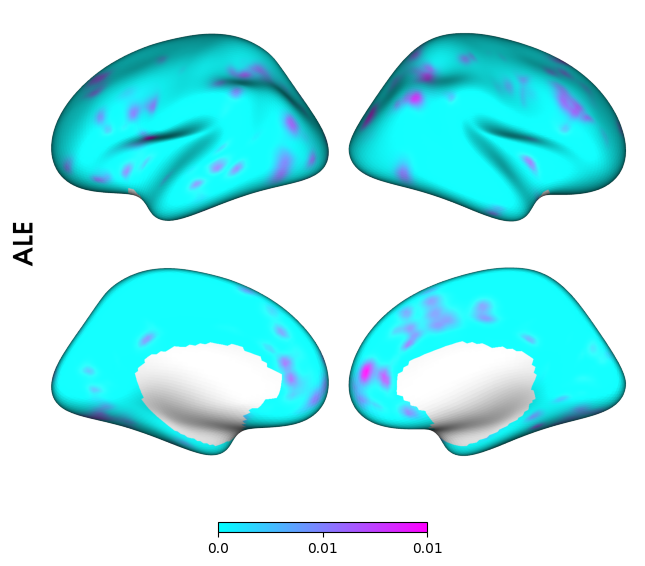

In [20]:
from neuromaps.datasets import fetch_fsaverage
from surfplot import Plot
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

# mask the medial wall first 
ALE_raw_fsa5_lh_data[np.logical_not(med_lh_data)] = 0
ALE_raw_fsa5_rh_data[np.logical_not(med_rh_data)] = 0

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['ALE']}, brightness=.8)
p.add_layer({'left': ALE_raw_fsa5_lh_data, 'right': ALE_raw_fsa5_rh_data}, cmap='cool', cbar=True)
fig = p.build()
fig.show()

#### rescale to 0-1

In [35]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
ALE_raw_scaled_data = min_max_scaler.fit_transform(ALE_raw_data.reshape(-1, 1))
ALE_FWE_scaled_data = min_max_scaler.fit_transform(ALE_FWE_data.reshape(-1, 1))
ALE_Z_scaled_data = min_max_scaler.fit_transform(ALE_Z_data.reshape(-1, 1))

/tmp/ipykernel_8617/2193828557.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


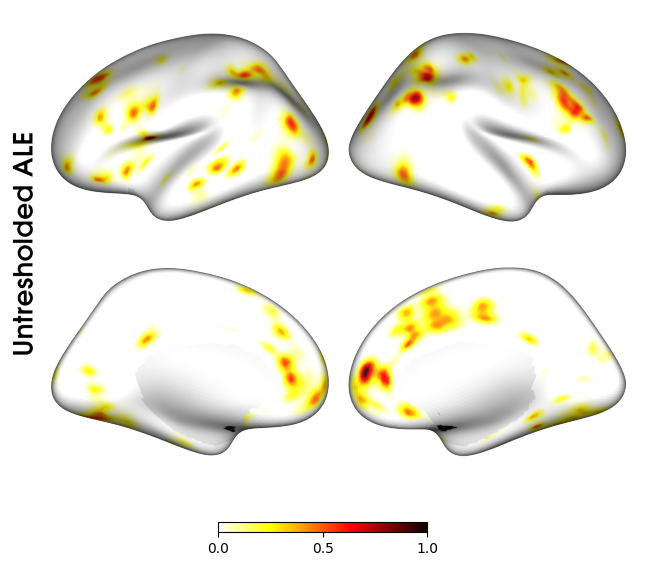

In [38]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Untresholded ALE']}, brightness=.8)
p.add_layer(ALE_raw_scaled_data.reshape([20484]), cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_scaled_Michigan_FEOBV_inflated_grid.png', dpi=300)

/tmp/ipykernel_8617/4174446521.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


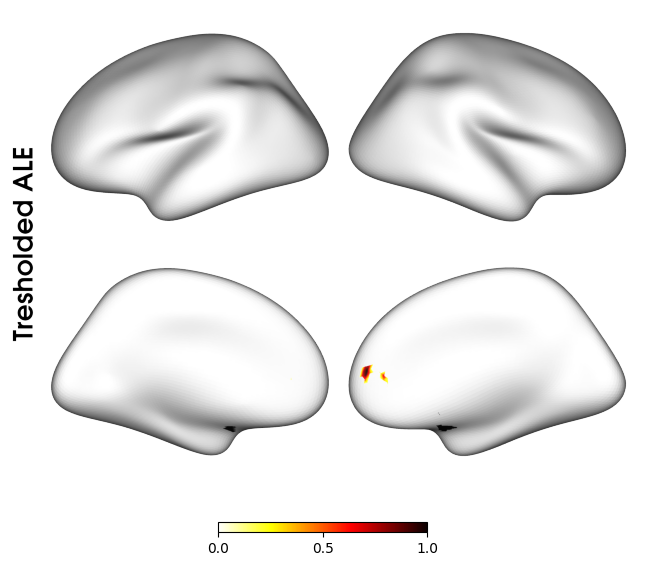

In [39]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Tresholded ALE']}, brightness=.8)
p.add_layer(ALE_FWE_scaled_data.reshape([20484]), cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_scaled_Michigan_FEOBV_inflated_grid.png', dpi=300)

/tmp/ipykernel_8617/3271432126.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


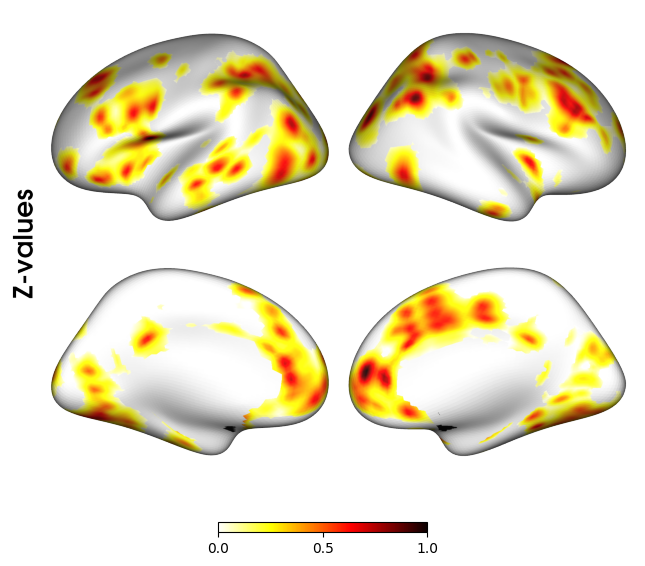

In [40]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Z-values']}, brightness=.8)
p.add_layer(ALE_Z_scaled_data.reshape([20484]), cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_scaled_Michigan_FEOBV_inflated_grid.png', dpi=300)

### parcellate -> rescale ALE maps

In [43]:
# load the hcp-mmp1 parcellation gii file
# or fetch the file
# glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [44]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

In [45]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [47]:
ALE_raw_parc = hcpmmp.transform(ALE_raw_data, 'fsaverage', ignore_background_data=True)
ALE_FWE_parc = hcpmmp.transform(ALE_FWE_data, 'fsaverage', ignore_background_data=True)
ALE_Z_parc = hcpmmp.transform(ALE_Z_data, 'fsaverage', ignore_background_data=True)

In [50]:
min_max_scaler = preprocessing.MinMaxScaler()
ALE_raw_parc_scaled_data = min_max_scaler.fit_transform(ALE_raw_parc.reshape(-1, 1))
ALE_FWE_parc_scaled_data = min_max_scaler.fit_transform(ALE_FWE_parc.reshape(-1, 1))
ALE_Z_parc_scaled_data = min_max_scaler.fit_transform(ALE_Z_parc.reshape(-1, 1))

In [80]:
ALE_raw_parc_scaled_data.shape

(360, 1)

In [81]:
ALE_parc_rescaled_data = {'raw':ALE_raw_parc_scaled_data.reshape([360]), 'FWE':ALE_FWE_parc_scaled_data.reshape([360]), 
                          'Z':ALE_Z_parc_scaled_data.reshape([360])}
ALE_parc_rescaled_df = pd.DataFrame(data=ALE_parc_rescaled_data)

#### Visualize

In [52]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [53]:
ALE_raw_cortex = map_to_labels(ALE_raw_parc_scaled_data.reshape([360]),surf_labels, mask=mask, fill=np.nan)
ALE_FWE_cortex = map_to_labels(ALE_FWE_parc_scaled_data.reshape([360]),surf_labels, mask=mask, fill=np.nan)
ALE_Z_cortex = map_to_labels(ALE_Z_parc_scaled_data.reshape([360]),surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_8617/2009355194.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


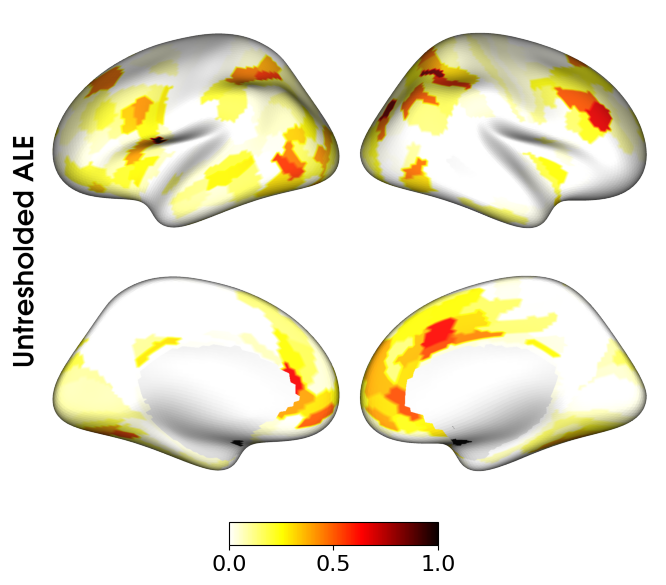

In [56]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Untresholded ALE']},brightness=.8)
p.add_layer(ALE_raw_cortex, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

/tmp/ipykernel_8617/963667717.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


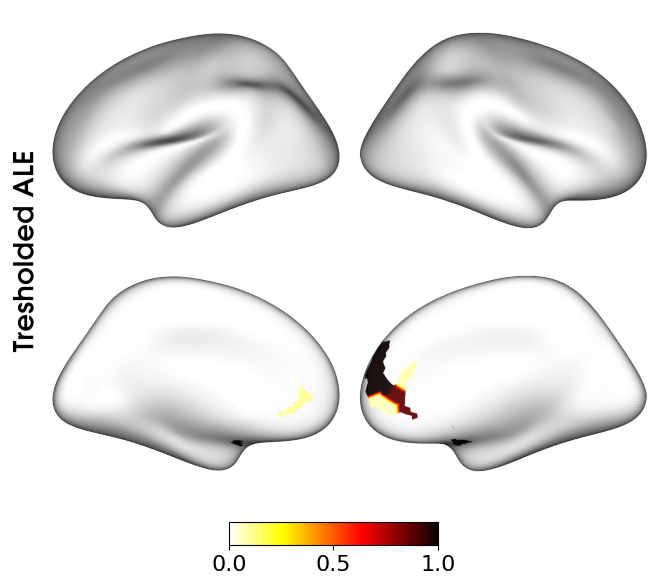

In [57]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Tresholded ALE']},brightness=.8)
p.add_layer(ALE_FWE_cortex, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

/tmp/ipykernel_8617/1703267217.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


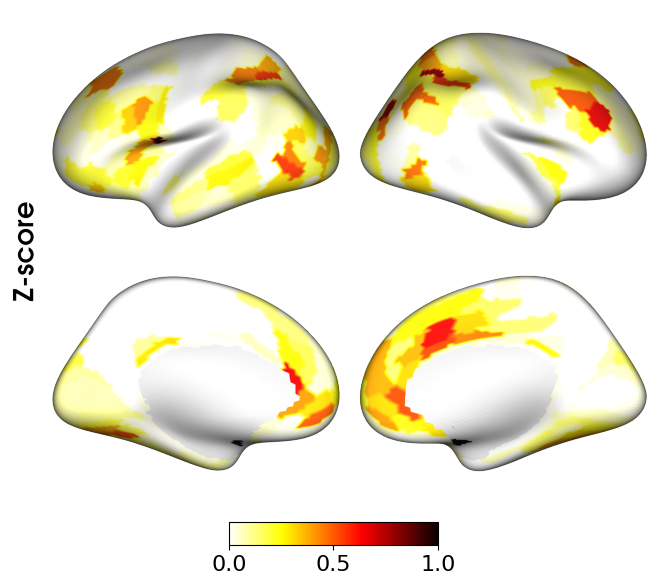

In [58]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Z-score']},brightness=.8)
p.add_layer(ALE_raw_cortex, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

### Load FEOBV and other data

In [59]:
wholeB_df = pd.read_csv(data_path + 'rescaled_whole_brain_data.csv')

In [62]:
wholeB_df

,labels,geodesic,myelin,Michigan_FEOBV,Aghourian_FEOBV,Bedard_FEOBV,Tuominen_FEOBV,functional,structural,wresidC
0,54,0.796473,0.854568,0.054785,0.417560,0.204726,0.265337,0.469834,0.415276,0.010250
1,46,0.911204,0.691224,0.212449,0.318734,0.160899,0.193347,0.210992,0.404432,0.119060
2,41,0.564919,0.721838,0.507094,0.553509,0.358201,0.382737,0.521383,0.114198,0.179069
3,87,0.552300,0.641402,0.266954,0.271154,0.194378,0.198943,0.341724,0.418003,0.102859
4,99,0.450188,0.707502,0.417403,0.466666,0.282197,0.304123,0.377407,0.144557,0.410765
...,...,...,...,...,...,...,...,...,...,...
20479,314,0.536869,0.601904,0.335280,0.353282,0.197097,0.119830,0.777940,0.342632,0.029628
20480,314,0.517557,0.604135,0.376565,0.273815,0.195053,0.146286,0.777940,0.342632,0.029628
20481,315,0.500530,0.611836,0.352042,0.274612,0.208627,0.156769,0.813672,0.429926,0.014712
20482,315,0.508823,0.638348,0.336323,0.278700,0.220988,0.183969,0.813672,0.429926,0.014712


In [60]:
parc_rescaled = pd.read_csv(data_path + 'parc_rescaled_all_data.csv')

In [61]:
parc_rescaled

,Geodesic,Myelin,Michigan_FEOBV,Aghourian_FEOBV,Bedard_FEOBV,Tuominen_FEOBV,functional,structural,wresidC
0,0.718208,0.725158,0.307165,0.284614,0.040923,0.196568,0.563640,0.805695,0.100994
1,0.756606,0.635854,0.393784,0.401920,0.107447,0.209680,0.164174,0.112599,0.050152
2,0.756608,0.647891,0.341122,0.303877,0.042400,0.192183,0.138740,0.433660,0.051173
3,0.719054,0.671180,0.280373,0.227710,0.032227,0.171076,0.377697,0.731491,0.044553
4,0.779794,0.632432,0.181810,0.279805,0.076867,0.147329,0.315332,0.684552,0.026488
...,...,...,...,...,...,...,...,...,...
355,0.442331,0.256823,0.554505,0.459290,0.254334,0.247783,0.595161,0.202580,0.426654
356,0.560568,0.266042,0.289936,0.372814,0.175223,0.167511,0.549909,0.163962,0.110377
357,0.216424,0.161699,0.678257,0.426209,0.311874,0.437831,0.547436,0.294434,0.317268
358,0.309827,0.227378,0.695732,0.673738,0.280750,0.338893,0.557818,0.181482,0.411807


In [63]:
Geodesic_parc_scaled_data = parc_rescaled['Geodesic'].values
Myelin_parc_scaled_data = parc_rescaled['Myelin'].values
MicCorr_parc_scaled_data = parc_rescaled['Michigan_FEOBV'].values
Aghourian_parc_scaled_data = parc_rescaled['Aghourian_FEOBV'].values
Bedard_parc_scaled_data = parc_rescaled['Bedard_FEOBV'].values
Tuominen_parc_scaled_data = parc_rescaled['Tuominen_FEOBV'].values

wresid_parc = parc_rescaled['wresidC'].values

In [65]:
Geodesic_parc_scaled_data.shape

(360,)

In [66]:
sum_lh = images.load_gifti(data_path + "Parc-Inv-rescaled_metric-average_L_fsa-10k.shape.gii")
sum_rh = images.load_gifti(data_path + "Parc-Inv-rescaled_metric-average_R_fsa-10k.shape.gii")

In [67]:
sum_lh_data = sum_lh.agg_data()
sum_rh_data = sum_rh.agg_data()
sum_data = np.concatenate((sum_lh_data, sum_rh_data))

In [76]:
sum_data.shape

(20484,)

/tmp/ipykernel_8617/3253411786.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


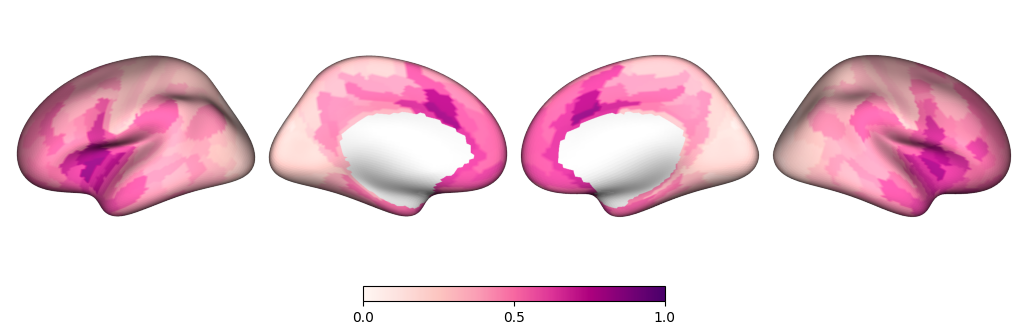

In [70]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, brightness=.8, layout='row', mirror_views=True)
p.add_layer(sum_data.reshape([20484]), cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()

In [72]:
sum_parc = hcpmmp.transform(sum_data, 'fsaverage', ignore_background_data=True)

In [77]:
sum_parc.shape

(360,)

In [78]:
sum_parc_cortex = map_to_labels(sum_parc,surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_8617/2421149167.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


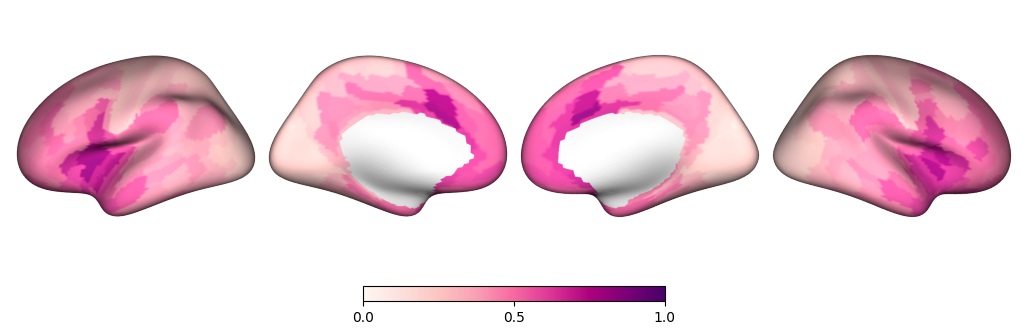

In [79]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, brightness=.8, layout='row', mirror_views=True)
p.add_layer(sum_parc_cortex, cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()

### Spin Tests using null model

In [83]:
ALE_parc_rescaled_df

,raw,FWE,Z
0,0.092566,0.000000,0.366272
1,0.445388,0.000000,0.660341
2,0.010760,0.000000,0.177181
3,0.113536,0.000000,0.367692
4,0.197138,0.000000,0.482101
...,...,...,...
355,0.001789,0.000000,0.095929
356,0.000590,0.000000,0.098637
357,0.008786,0.000000,0.172404
358,0.381689,0.000000,0.576755


In [85]:
ALE_parc_scaled_data = ALE_parc_rescaled_df['raw'].values
FWE_parc_scaled_data = ALE_parc_rescaled_df['FWE'].values
Z_parc_scaled_data = ALE_parc_rescaled_df['Z'].values

In [82]:
# set #permutations
n_perm = 10000

In [86]:
ALE_raw_parc_rotated = nulls.alexander_bloch(ALE_parc_scaled_data, atlas='fsaverage', density='10k',
                                             n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [90]:
FEOBV_ALE_corr, FEOBV_ALE_pval = stats.compare_images(ALE_parc_scaled_data, MicCorr_parc_scaled_data, nulls=ALE_raw_parc_rotated)
FEOBV_ALE_corr, FEOBV_ALE_pval

(-0.06312295969273272, 0.639036096390361)

In [91]:
sum_ALE_corr, sum_ALE_pval = stats.compare_images(ALE_parc_scaled_data, sum_parc, nulls=ALE_raw_parc_rotated)
sum_ALE_corr, sum_ALE_pval

(0.03836589306592941, 0.6705329467053295)

In [88]:
Z_parc_rotated = nulls.alexander_bloch(Z_parc_scaled_data, atlas='fsaverage', density='10k',
                                           n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [93]:
FEOBV_Z_corr, FEOBV_Z_pval = stats.compare_images(Z_parc_scaled_data, MicCorr_parc_scaled_data, nulls=Z_parc_rotated)
FEOBV_Z_corr, FEOBV_Z_pval

(-0.05718377406304023, 0.6567343265673433)

In [94]:
sum_Z_corr, sum_Z_pval = stats.compare_images(Z_parc_scaled_data, sum_parc, nulls=Z_parc_rotated)
sum_Z_corr, sum_Z_pval

(0.01795600913465023, 0.8631136886311369)

### Scatter plots

#### Yeo network ref

In [95]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap)

/tmp/ipykernel_8617/1262307927.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


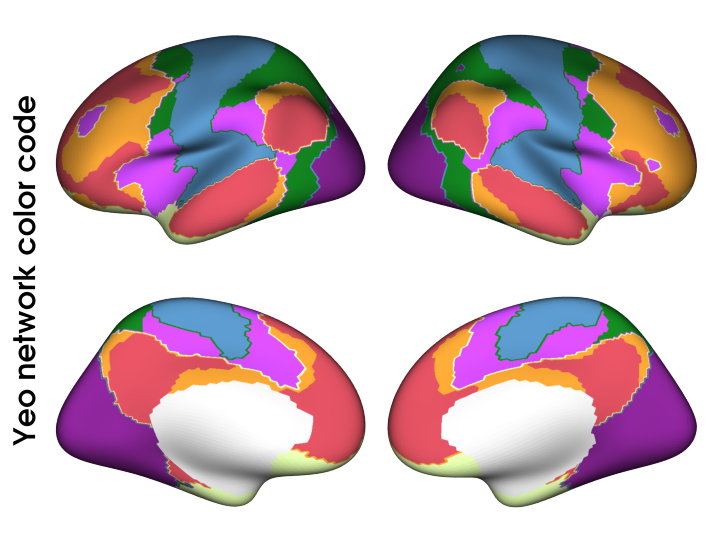

In [98]:
# Visualize network color ref

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['Yeo network color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()

In [97]:
network_parc = hcpmmp.transform(yeo_networks, 'fsaverage', ignore_background_data=True)

#### correlations

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


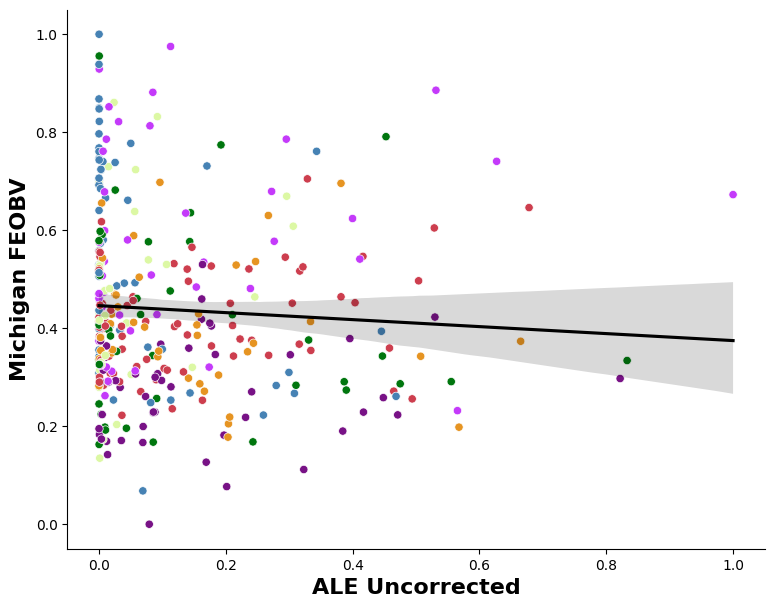

In [99]:
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(ALE_parc_scaled_data, MicCorr_parc_scaled_data, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('ALE Uncorrected', weight='bold', fontsize=16)
ax1.set_ylabel('Michigan FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=ALE_parc_scaled_data, 
    y=MicCorr_parc_scaled_data,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


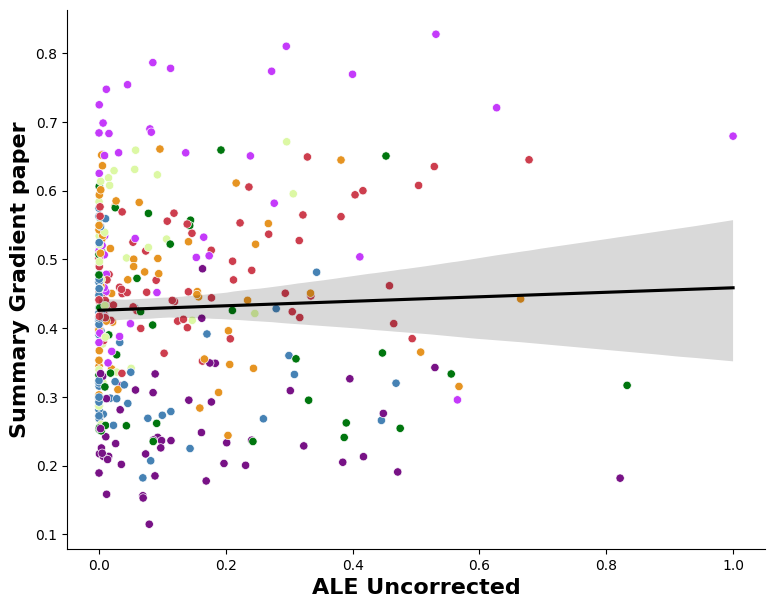

In [100]:
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(ALE_parc_scaled_data, sum_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('ALE Uncorrected', weight='bold', fontsize=16)
ax1.set_ylabel('Summary Gradient paper', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=ALE_parc_scaled_data, 
    y=sum_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


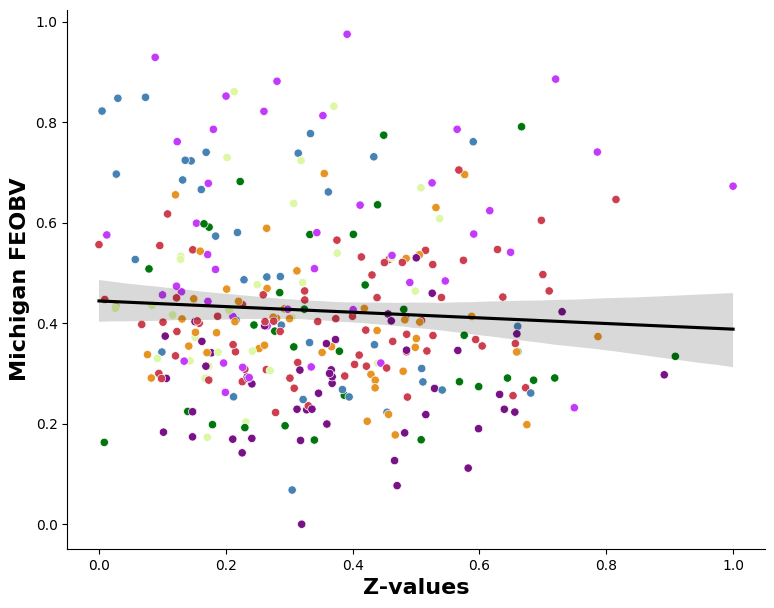

In [101]:
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(Z_parc_scaled_data, MicCorr_parc_scaled_data, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Z-values', weight='bold', fontsize=16)
ax1.set_ylabel('Michigan FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=Z_parc_scaled_data, 
    y=MicCorr_parc_scaled_data,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


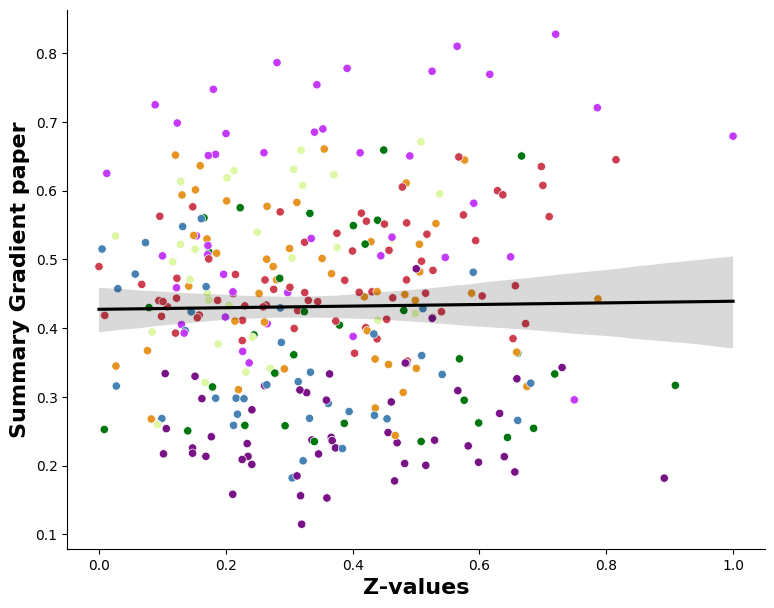

In [102]:
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(Z_parc_scaled_data, sum_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Z-values', weight='bold', fontsize=16)
ax1.set_ylabel('Summary Gradient paper', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=Z_parc_scaled_data, 
    y=sum_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()